# How to Open Roman Data Files (ASDF)

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Imports

- *numpy* for array operations
- *asdf* for ASDF input/output
- *roman_datamodels* to handle input/output and validation of data models
- *matplotlib.pyplot* for plotting data
- *astropy.units* to handle units
- *astropy.time* to handle time
- *astropy.coordinates* to handle celestial coordinates
- *pprint* for enhanced printing

In [1]:
%matplotlib inline
import numpy as np
import asdf
import roman_datamodels as rdm
from roman_datamodels.dqflags import pixel as dqflags
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.time
from astropy.coordinates import SkyCoord
from pprint import pprint
import s3fs

## Introduction

The main goal of this notebook is to illustrate how to open and handle Roman Wide Field Instrument (WFI) data. WFI data are stored in [Advanced Scientific Data Format (ASDF)](https://asdf-standard.readthedocs.io/) files, which combine human-readable hierarchical metadata structure with binary array data. ASDF files are self-validating using pre-defined schema.

There are tools to interact with ASDF files in Python, Julia, C/C++, and IDL. In this example we focus on the Python interface.

Roman ASDF files can be opened and manipulated using two main approaches: 
1. using the `roman_datamodels` library, and
2. using the `asdf` library.

Using `roman_datamodels` offers the advantage of loading different data blocks as `stnode`-based objects, providing access to their methods. In contrast, the `asdf` library loads the data blocks as they were serialized on disk. While this approach loses some of the `roman_datamodels` capabilities, it also provides more flexibility. In this notebook, we illustrate both approaches, starting with loading data via `roman_datamodels`.

Additional information about Roman ASDF files can be found in the [Introduction to ASDF](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/introduction-to-asdf) article on RDox.

***

## Quick start

All Roman data products conform to one of the datamodels described by the [`roman_datamodels`](https://roman-datamodels.readthedocs.io/en/latest/) package. This package wraps the `asdf` library and provides utilities to read and save data conforming to the official data models. We illustrate how to use `roman_datamodels` to load data from an ASDF file containing simulated Roman data.

In [2]:
asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
fs = s3fs.S3FileSystem(anon=True)

asdf_file_uri_l2 = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_cal.asdf'

with fs.open(asdf_file_uri_l2, 'rb') as fb:
    af = asdf.open(fb)
    f = rdm.open(af).copy()

Notice that we used the `asdf.open()` command to open the byte stream, and then passed that object to `roman_datamodels.open()`. This is necessary at present as `roman_datamodels` does not allow for reading of a byte stream in this manner.

A high-level summary of the file can be retrieved by using the `info()` method. We have limited the number of rows printed to 30, but if you want to see all rows, you can change that number to your liking or to `None` in order to see all rows. There is a similar option for `max_cols` if you want to change the horizontal cutoff per line. The default number of rows and columns is 24 and 120, respectively.

In [3]:
f.info(max_rows=30)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   ├─[1] (ExtensionMetadata) ...
│   ├─[2] (ExtensionMetadata) ...
│   └─4 not shown
└─roman (WfiImage) # Level 2 (L2) Calibrated Roman Wide Field Instrument (WFI) Rate Image.
  ├─meta (dict) ...
  ├─data (ndarray) # Science Data (DN/s) or (MJy/sr) ...
  ├─dq (ndarray) # Data Quality ...
  ├─err (ndarray) # Error (DN / s) or (MJy / sr) ...
  ├─var_poisson (ndarray) # Poisson Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_rnoise (ndarray) # Read Noise Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_flat (ndarray) # Flat Field Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─amp33 (ndarray) # Amplifier 33 Reference Pixel Data (DN) ...
  ├─border_ref_pix_left (ndarray) # Left-Edge Border Reference Pixels (DN) ...
  ├─border_ref_pix_right (n

Note that, by default, the `open()` method does not load the data in memory unless told to do so explicitly, which makes opening ASDF files a quick operation. 

At this point, we have information about the names and types of the different data blocks, but we don't have access to the data until we load them, which we can do by using them. For example:

In [4]:
f.data

array([[0.3828592 , 0.7190066 , 0.57954526, ..., 0.82491654, 0.54798466,
        0.7596621 ],
       [0.48790407, 0.5191181 , 0.68121314, ..., 0.8290943 , 0.7378703 ,
        0.31645823],
       [0.65960026, 0.62473404, 0.7867249 , ..., 0.63130987, 0.67372173,
        0.56940955],
       ...,
       [0.69034207, 1.0855403 , 0.6050965 , ..., 0.75234616, 0.7595161 ,
        0.77993363],
       [0.66153103, 0.7590605 , 0.6202591 , ..., 0.6739805 , 0.33642223,
        0.6299567 ],
       [0.6038647 , 0.9196994 , 0.8665242 , ..., 0.        , 0.        ,
        0.55580723]], shape=(4088, 4088), dtype=float32)

An ASDF object can be used, effectively, like a nested dictionary. Each block can be explored via the `.keys()` attribute. For example, we can retrieve the list of keys in a Level 2 calibrated rate image file as:

In [5]:
for key in f.keys():
    print(key)

meta
data
dq
err
var_poisson
var_rnoise
var_flat
amp33
border_ref_pix_left
border_ref_pix_right
border_ref_pix_top
border_ref_pix_bottom
dq_border_ref_pix_left
dq_border_ref_pix_right
dq_border_ref_pix_top
dq_border_ref_pix_bottom


We can also find all of the keys within one of these blocks, such as the metadata. Note that here we are using the dot syntax notation (i.e., `f.meta`) to retrieve the metadata. You can also use brackets to subscript the datamodel (e.g., `f['meta']`). Dot syntax is allowed by datamodel objects in `roman_datamodels`, whereas ASDF objects (shown later in the tutorial) can only use the bracket subscript notation.

In [6]:
for key in f.meta.keys():
    print(key)

asn
cal_logs
cal_step
calibration_software_name
calibration_software_version
coordinates
ephemeris
exposure
exptype
file_date
filename
group_id
guide_star
instrument
model_type
observation
origin
photometry
pointing
prd_version
product_type
program
rcs
ref_file
sdf_software_version
source_catalog
telescope
velocity_aberration
visit
wcs
wcs_fit_results
wcsinfo


We focus on the data block, containing the science image of interest. First, how do we know which array in the file is the primary data array? It could have any name, for example "data" or "science." If we are not sure, we can ask the file itself:

In [7]:
f.get_primary_array_name()

'data'

The creators of the datamodel have told us explicitly that the primary array name in this case is "data." This may not be true for all Roman WFI ASDF files (e.g., calibration reference files), so it is always worth checking if you are not sure. Next, let's look at the type of the `data` block:

In [8]:
type(f.data)

numpy.ndarray

Note that Roman images are expressed as `numpy.ndarray` objects. The units are available in the schema descriptions for the arrays (see below), but quickly the data arrays are:

- Level 1 (L1; uncalibrated 3-D ramp cubes) are in units of Data Numbers (DN)
- Level 2 (L2; calibrated 2-D rate images) are in units of DNs per second (DN/s)
- Level 3 (L3; 2-D mosaic co-adds) are in units of megaJanskys per steradian (MJy/sr)

Error arrays are in the same units as data, and variance arrays are the same units squared (e.g., DN^2 / s^2).

Let's take a look at the size of our image and some sample values in a small 3x3 cutout from the bottom-left corner of the array:

In [9]:
print('Size of f.data: ', f.data.shape)
print('\nExploring the values of f.data: \n', f.data[:3, :3])

Size of f.data:  (4088, 4088)

Exploring the values of f.data: 
 [[0.3828592  0.7190066  0.57954526]
 [0.48790407 0.5191181  0.68121314]
 [0.65960026 0.62473404 0.7867249 ]]


Since we have image data, let's also take a quick look at what the image actually contains. This is quite simple, and a more detailed explanation about visualizing Roman ASDF files can be found in the [Data Visualization](../data_visualization/data_visualization.ipynb) tutorial. Below is a 1,000 x 1,000 pixel section of the data array:

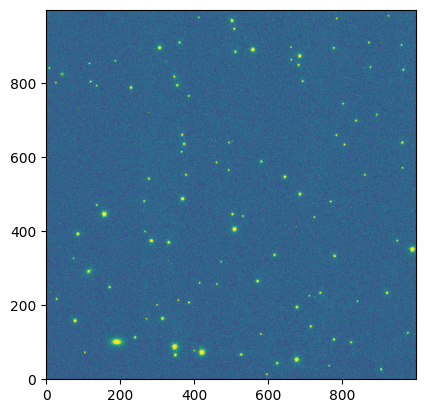

In [10]:
plt.imshow(f.data[:1000, :1000], vmin=0, vmax=2, origin='lower');

As with array data stored in other file types, we can perform analyses on the arrays in memory. For example, we can check the image content by building a 1-D histogram of the its values:

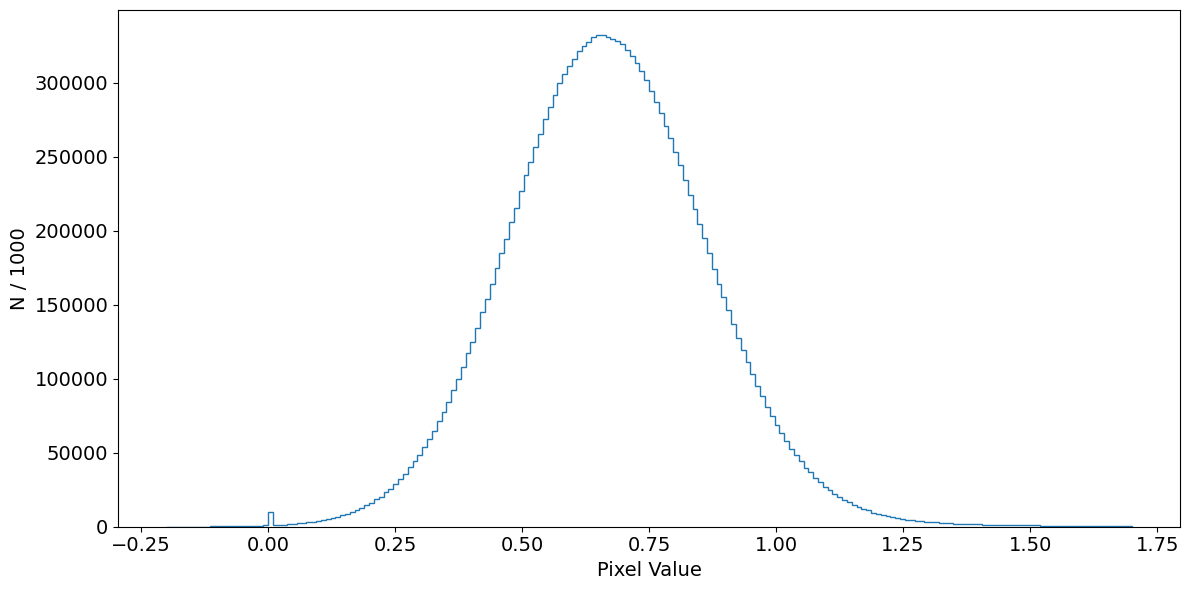

In [11]:
fig, ax = plt.subplots(figsize=(12, 6), layout='tight')
ax.hist(f.data.flatten(), histtype='step', range=(-0.2, 1.7), bins=200);
ax.set_xlabel('Pixel Value', fontsize=14)
ax.set_ylabel('N / 1000', fontsize=14)
ax.tick_params(axis='both', labelsize=14);

We can explore other data blocks such as the data quality (DQ) array. The values of the DQ array are the bitwise sum of the individual flags representing specific effects. These flags are defined in the [RomanCal documentation](https://roman-pipeline.readthedocs.io/en/latest/roman/references_general/references_general.html#data-quality-flags). These can also be retrieved from `roman_datamodels.dqflags.pixel()`. As a reminder, we aliased `roman_datamodels.dqflags.pixel()` in our import statement at the start of the tutorial as `dqflags()`. Let's start by making a list of all of the unique values in the DQ array:

In [12]:
unique_dq = np.unique(f.dq)
print(unique_dq)

[       0        1        4     1025     1027     1029     8192     8195
     8196     8197     9217     9219     9221    65536    65537    65539
    65540    66561    66563    66565    73728    73729    73732    74753
    74757  1048576  1048577  1049601  1056768  1056769  1057793  1114112
  1114113  1115137  1122304  1122305  1123329 33554432 33554433 33554436
 33554437 33555457 33555459 33555461 33562624 33562625 33562627 33562628
 33562629 33563649 33563651 33563653 33619968 33619969 33619971 33619972
 33619973 33620993 33620995 33620997 33628160 33628161 33628163 33628164
 33628165 33629185 33629187 33629189 34603008 34603009 34604033 34604035
 34604037 34611200 34611201 34611203 34612225 34612227 34612229 34668544
 34668545 34669569 34669571 34676736 34676737 34676739 34677761 34677763]


Now that we have the list of unique DQ values, we can decompose the values into individual flags and print the number of pixels with each unique DQ value:

In [13]:
size = np.size(f.dq)

# Number of good pixels
npix = np.shape(f.dq[f.dq==0])[0]
print("------------")
print(f'Flag 0 (affected pixels = {npix}; {npix / size:.2%}))')
print(f'0: {str(dqflags(0)).split('.')[1]}')

# Pixels with non-zero DQ flags
for uu in unique_dq[1:]:
    br = np.binary_repr(uu)
    npix = np.shape(f.dq[f.dq==uu])[0]
    print("------------")
    print(f'Flag {uu} (affected pixels = {npix}; {npix / size:.2%})')
    for ii, cc in enumerate(br[::-1]):
        if int(cc)==1:
            print(f'{2**ii}: {str(dqflags(2**ii)).split('.')[1]}')

------------
Flag 0 (affected pixels = 16045479; 96.01%))
0: GOOD
------------
Flag 1 (affected pixels = 4; 0.00%)
1: DO_NOT_USE
------------
Flag 4 (affected pixels = 4446; 0.03%)
4: JUMP_DET
------------
Flag 1025 (affected pixels = 1439; 0.01%)
1: DO_NOT_USE
1024: DEAD
------------
Flag 1027 (affected pixels = 33; 0.00%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
------------
Flag 1029 (affected pixels = 92; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
1024: DEAD
------------
Flag 8192 (affected pixels = 642834; 3.85%)
8192: LOW_QE
------------
Flag 8195 (affected pixels = 1; 0.00%)
1: DO_NOT_USE
2: SATURATED
8192: LOW_QE
------------
Flag 8196 (affected pixels = 188; 0.00%)
4: JUMP_DET
8192: LOW_QE
------------
Flag 8197 (affected pixels = 2; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
8192: LOW_QE
------------
Flag 9217 (affected pixels = 182; 0.00%)
1: DO_NOT_USE
1024: DEAD
8192: LOW_QE
------------
Flag 9219 (affected pixels = 4; 0.00%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
8192: LOW_QE
------------
Flag 9

------------
Flag 66561 (affected pixels = 121; 0.00%)
1: DO_NOT_USE
1024: DEAD
65536: NONLINEAR
------------
Flag 66563 (affected pixels = 5; 0.00%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
65536: NONLINEAR
------------
Flag 66565 (affected pixels = 21; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
1024: DEAD
65536: NONLINEAR


------------
Flag 73728 (affected pixels = 96; 0.00%)
8192: LOW_QE
65536: NONLINEAR
------------
Flag 73729 (affected pixels = 2; 0.00%)
1: DO_NOT_USE
8192: LOW_QE
65536: NONLINEAR
------------
Flag 73732 (affected pixels = 2; 0.00%)
4: JUMP_DET
8192: LOW_QE
65536: NONLINEAR
------------
Flag 74753 (affected pixels = 88; 0.00%)
1: DO_NOT_USE
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
------------
Flag 74757 (affected pixels = 3; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
------------
Flag 1048576 (affected pixels = 213; 0.00%)
1048576: NO_LIN_CORR
------------
Flag 1048577 (affected pixels = 161; 0.00%)
1: DO_NOT_USE
1048576: NO_LIN_CORR
------------
Flag 1049601 (affected pixels = 80; 0.00%)
1: DO_NOT_USE
1024: DEAD
1048576: NO_LIN_CORR
------------
Flag 1056768 (affected pixels = 38; 0.00%)
8192: LOW_QE
1048576: NO_LIN_CORR
------------
Flag 1056769 (affected pixels = 33; 0.00%)
1: DO_NOT_USE
8192: LOW_QE
1048576: NO_LIN_CORR
------------
Flag 1057793 (af

------------
Flag 33554436 (affected pixels = 135; 0.00%)
4: JUMP_DET
33554432: UNRELIABLE_FLAT
------------
Flag 33554437 (affected pixels = 33; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
33554432: UNRELIABLE_FLAT
------------
Flag 33555457 (affected pixels = 1067; 0.01%)
1: DO_NOT_USE
1024: DEAD
33554432: UNRELIABLE_FLAT


------------
Flag 33555459 (affected pixels = 51; 0.00%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
33554432: UNRELIABLE_FLAT
------------
Flag 33555461 (affected pixels = 126; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
1024: DEAD
33554432: UNRELIABLE_FLAT
------------
Flag 33562624 (affected pixels = 254; 0.00%)
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33562625 (affected pixels = 2; 0.00%)
1: DO_NOT_USE
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33562627 (affected pixels = 10; 0.00%)
1: DO_NOT_USE
2: SATURATED
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33562628 (affected pixels = 108; 0.00%)
4: JUMP_DET
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33562629 (affected pixels = 46; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33563649 (affected pixels = 24; 0.00%)
1: DO_NOT_USE
1024: DEAD
8192: LOW_QE
33554432: UNRELIABLE_FLAT
------------
Flag 33563651 (affected pixels = 208; 0.00%)
1: DO_NOT_USE
2: SA

------------
Flag 33628161 (affected pixels = 3; 0.00%)
1: DO_NOT_USE
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 33628163 (affected pixels = 4; 0.00%)
1: DO_NOT_USE
2: SATURATED
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 33628164 (affected pixels = 6; 0.00%)
4: JUMP_DET
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT


------------
Flag 33628165 (affected pixels = 7; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 33629185 (affected pixels = 14; 0.00%)
1: DO_NOT_USE
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 33629187 (affected pixels = 4; 0.00%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 33629189 (affected pixels = 2; 0.00%)
1: DO_NOT_USE
4: JUMP_DET
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
33554432: UNRELIABLE_FLAT
------------
Flag 34603008 (affected pixels = 127; 0.00%)
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34603009 (affected pixels = 5; 0.00%)
1: DO_NOT_USE
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34604033 (affected pixels = 1248; 0.01%)
1: DO_NOT_USE
1024: DEAD
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34604035 (affected pixels = 1665; 0.01%)
1: DO_NOT_USE

------------
Flag 34676736 (affected pixels = 153; 0.00%)
8192: LOW_QE
65536: NONLINEAR
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34676737 (affected pixels = 35; 0.00%)
1: DO_NOT_USE
8192: LOW_QE
65536: NONLINEAR
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34676739 (affected pixels = 2; 0.00%)
1: DO_NOT_USE
2: SATURATED
8192: LOW_QE
65536: NONLINEAR
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT


------------
Flag 34677761 (affected pixels = 943; 0.01%)
1: DO_NOT_USE
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT
------------
Flag 34677763 (affected pixels = 2892; 0.02%)
1: DO_NOT_USE
2: SATURATED
1024: DEAD
8192: LOW_QE
65536: NONLINEAR
1048576: NO_LIN_CORR
33554432: UNRELIABLE_FLAT


If we want to get a report of how many pixels are impacted by specific DQ flags (e.g., all saturated pixels) regardless of other flags set, we can do that, too using the Python `&` operator (bitwise AND) and the bitwise left shift `<<` operator:

In [14]:
bit = 2
definition = str(dqflags(bit)).split('.')[1]
n_pix = np.sum(np.bool(f.dq.flatten() & (1 << bit)))
print(f'Bit value {bit} corresponds to {definition}')
print(f'Number of {definition} pixels: {n_pix:,} ({n_pix / f.dq.size:.2%})')

Bit value 2 corresponds to SATURATED
Number of SATURATED pixels: 5,285 (0.03%)


## Exploring metadata

One of the advantages of ASDF is its extensibility, and the ability to store human-readable hierarchical metadata. Let's further explore the metadata.

In [15]:
meta = f['meta']
type(meta)

dict

As we can see, `meta` is a dictionary type object. What if instead of using the bracket notation we use the dot notation discussed previously?

In [16]:
meta = f.meta
type(meta)

roman_datamodels.stnode._node.DNode

Suddenly it's a `roman_datamodels.stnode._node.DNode` object! Despite this difference in object type, we can treat both this and a dictionary the same in most ways. However, an advantage of the dot syntax and the `roman_datamodels.stnode._node.DNode` object is that we retain information about the schema, which we lose if we convert the metadata to a dictionary object. We previously showed how to get the list of keys in the metadata, but as a reminder let's do it again here for easy reference:

In [17]:
for key in meta.keys():
    print(key)

asn
cal_logs
cal_step
calibration_software_name
calibration_software_version
coordinates
ephemeris
exposure
exptype
file_date
filename
group_id
guide_star
instrument
model_type
observation
origin
photometry
pointing
prd_version
product_type
program
rcs
ref_file
sdf_software_version
source_catalog
telescope
velocity_aberration
visit
wcs
wcs_fit_results
wcsinfo


Printing the whole of the metadata is quite long, so we will instead print a small subsection:

In [18]:
print(meta.instrument)

{'detector': 'WFI01', 'optical_element': 'F106', 'name': 'WFI'}


As shown above, the `meta` data block contains a lot of useful metadata information. Two of the most typical keys, for example, are the `wcs` key, containing information about the World Coordinate System (WCS; see below), and also the `photometry` key, containing information about how to transform units from instrumental (DN/s) to physical (MJy/sr).

Let's take a look at the schema information for `meta.instrument`. Note that this can be quite difficult to read, but is very rich in information about the contents, data types, allowed values, and mapping to other information (e.g., the storage location of a metadata field in the MAST Archive Catalog database) for every component of Roman WFI ASDF files. Also notice that we use the `pprint()` function (instead of `print()`) to better display the text.

In [19]:
pprint(meta.instrument.get_schema())

{'$schema': 'asdf://stsci.edu/datamodels/roman/schemas/rad_schema-1.0.0',
 'flowStyle': 'block',
 'id': 'asdf://stsci.edu/datamodels/roman/schemas/wfi_mode-1.0.0',
 'properties': {'detector': {'allOf': [{'$schema': 'asdf://stsci.edu/datamodels/roman/schemas/rad_schema-1.0.0',
                                        'enum': ['WFI01',
                                                 'WFI02',
                                                 'WFI03',
                                                 'WFI04',
                                                 'WFI05',
                                                 'WFI06',
                                                 'WFI07',
                                                 'WFI08',
                                                 'WFI09',
                                                 'WFI10',
                                                 'WFI11',
                                                 'WFI12',
                           

We can also use this to get the description of a specific metadata field:

In [20]:
print(meta.instrument.get_schema()['properties']['detector']['description'])

Name of the Wide Field Instrument (WFI) detector used
to take the science data in this file.



This can be alternatively written as:

In [21]:
print(f.schema_info(path='roman.meta.instrument.detector'))

{'description': Name of the Wide Field Instrument (WFI) detector used
to take the science data in this file.
}


### Taking advantage of `astropy.time.Time` objects in the metadata

Another feature in WFI ASDF metadata is the storage of times as `astropy.time.Time` objects, which provide numerous convenient methods for converting to different reference systems and formats. Here we illustrate a few examples. For a more comprehensive view of `astropy.time` please check the [astropy.time](https://docs.astropy.org/en/stable/time/) documentation. Note that, unless otherwise noted, WFI times are stored in Coordinated Universal Time (UTC), which is indicated in the schema descriptions for any time-related fields. However, be sure to check the field descriptions if you are unsure.

In [22]:
start_time = meta.exposure.start_time
print('Start time of the exposure:', start_time, '; datatype:', type(start_time))

Start time of the exposure: 2026-10-31T00:00:00.000 ; datatype: <class 'astropy.time.core.Time'>


We can convert the format of this start time to a modified Julian date (MJD) very easily:

In [23]:
start_time.mjd

np.float64(61344.0)

If instead we want to convert the scale of the time (i.e., from UTC to International Atomic Time (TAI)), we can do that, too:

In [24]:
start_time.tai

<Time object: scale='tai' format='isot' value=2026-10-31T00:00:37.000>

Notice that the time changed by 37 seconds when we converted from UTC to TAI. This offset is expected and is part of the TAI definition. We can combine the scale change with the format change as well:

In [25]:
start_time.tai.mjd

np.float64(61344.00042824074)

We can use `Time` objects and operate with them. For example, if we want to know the difference in time between the start and end times of the exposure (this creates a `astropy.time.TimeDelta` object):

In [26]:
end_time = meta.exposure.end_time
exp_delta = end_time - start_time

And then express the exposure length in different units:

In [27]:
print('Exposure length in seconds:', exp_delta.to(u.s))
print('Exposure length in days:', exp_delta.to(u.day))
print('Exposure length in years:', exp_delta.to(u.year))

Exposure length in seconds: 51.67999999999324 s
Exposure length in days: 0.0005981481481480699 d
Exposure length in years: 1.637640378228802e-06 yr


### Accessing WCS Information

Roman uses Generalized World Coordinate System standard ([GWCS](https://gwcs.readthedocs.io)). The WCS can be found in the `wcs` key within the `meta` block.

In [28]:
gwcs = f.meta.wcs
print(type(gwcs))

<class 'gwcs.wcs._wcs.WCS'>


If we use the pretty-print (`pprint()`) function, we can see the full contents of the WCS object.

In [29]:
pprint(gwcs)

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] | [13] & [14] | [15] | [16] | [17] / [18] | [19] | [20] | [21] | [22] & [23] | [24] | [25] | [26] & [27] | [28] & [29] | [30] | [31] | [32]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-2044.5)>

    [3]: <Shift(offset=-2044.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=0., c1_0=0.11034133, c2_0=-0.00000003, c3_0=-0., c4_0=0., c5_0=-0., c0_1=0.00034168, c0_2=-0.00000001, c0_3=-0., c0_4=-0., c0_5=0., c1_1=0.00000014, c1_2=-0., c1_3=0., c1_4=0., c2_1=0., c2_2=-0., c2_3=-0., c3_1=0., c3_2=-0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00031436, c2_0=0.00000007, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.10828278, c0_2=0.00000021, c0_3=-0., c0_4=0., c0_5=0., c1_1=-0.00000002, c1

If instead we use the `print()` function, we get a summary of the transforms available:

In [30]:
print(gwcs)

   From                   Transform                
---------- ----------------------------------------
  detector                            CompoundModel
      v2v3                                 Identity
v2v3vacorr JWST tangent-plane linear correction. v1
  v2v3corr                                 v23tosky
     world                                     None


The `gwcs` object can be used to convert between image pixel and sky coordinates.

**Important note:** the `gwcs` object uses Python 0-indexing, therefore the center of the first pixel in Python is (0, 0), while the formal definition of the WFI science coordinate system uses FITS-style 1-indexing (i.e., the center of the bottom-left pixel is (1, 1)). More information about the Roman coordinate systems can be found in the [PySIAF for Roman](https://roman-docs.stsci.edu/simulation-tools-handbook-home/simulation-development-utilities/pysiaf-for-roman) article on RDox. **All** archived L1-4 data products (e.g., WCS transforms, catalogs, etc.) will use the Python 0-indexed system.

In this example, let's convert the central pixel position of the detector to the corresponding right ascension and declination on the sky. The center of the L2 image array in the zero-indexed science coordinate frame is (x, y) = (2043.5, 2043.5) pixels. Note that the 4-pixel reference border was removed during processing, and thus the total L2 image size is 4088 rows x 4088 columns. Since the center of the first pixel in Python is (0, 0) and the array size is even, the center of the detector is (x, y) = (2043.5, 2043.5). Also note that GWCS assumes inputs in the order (x, y) and not the Pythonic form (y, x).

In [31]:
print(gwcs(2043.5, 2043.5))

(270.8719765816213, -0.16439951042879608)


Likewise, we can convert from celestial coordinates to pixel coordinates using the inverse transform via the `.invert()` method. For example, using a slightly different position still within this detector:

In [32]:
print(gwcs.invert(270.8719, -0.164399))

[2045.998524527189, 2043.5097306351731]


Notice that `gwcs` assumed our inputs were the right ascension and declination, respectively, in degrees. If we want to be more specific, then the `gwcs` object can also take as input an `astropy.coordinates.SkyCoord` object:

In [33]:
cdt = SkyCoord(270.8719, -0.164399, unit='deg')
print(gwcs.invert(cdt))

[2045.998524527189, 2043.5097306351731]


## Reading Roman data using the ASDF library

We now illustrate how to read Roman WFI data using the basic `asdf` library.

The main avenue to read a generic ASDF file is via the `open` method in the `asdf` package. This returns an `AsdfObject` object.

In [34]:
asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
fs = s3fs.S3FileSystem(anon=True)

asdf_file_uri_l2 = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_cal.asdf'

with fs.open(asdf_file_uri_l2, 'rb') as fb:
    f = asdf.open(fb).copy()

Another useful method to explore the contents of an ASDF file is the `.tree` attribute:

In [35]:
pprint(f.tree) # This cell will print a lot of information, please feel free to skim or skip

{'asdf_library': {'author': 'The ASDF Developers',
                  'homepage': 'http://github.com/asdf-format/asdf',
                  'name': 'asdf',
                  'version': '4.1.0'},
 'history': {'extensions': [{'extension_class': 'asdf.extension._manifest.ManifestExtension',
                             'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.6.0',
                             'manifest_software': {'name': 'asdf_standard',
                                                   'version': '1.1.1'},
                             'software': {'name': 'asdf', 'version': '4.1.0'}},
                            {'extension_class': 'asdf.extension._manifest.ManifestExtension',
                             'extension_uri': 'asdf://stsci.edu/datamodels/roman/extensions/datamodels-1.0',
                             'manifest_software': {'name': 'rad',
                                                   'version': '0.23.1'},
                             'software': {'na

For WFI ASDF files, the three high-level blocks are: 
* `asdf_library`: It contains information about the `asdf` library used to create the file.
* `history`: It contains metadata information about the extensions used to create the file.
* `roman`: This block contains Roman data and metadata.

Within the `roman` block, the `data` block contains the data, which corresponds to an uncalibrated ramp in L1 products, a calibrated rate image in L2 products, and a mosaic image in L3 products.

Other interesting data blocks are: 
- `meta`: metadata information
- `err`: estimated uncertainties
- `dq`: data quality flags

For more information about these data blocks and Level 2 data products, please visit the [RDox pages on data levels and products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products#DataLevelsandProducts-level2).

We further showcase the usage of the `asdf` basic library below using a L1 file.

In [36]:
asdf_file_uri_l1 = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_uncal.asdf'

with fs.open(asdf_file_uri_l1, 'rb') as fb:
    g = asdf.open(fb).copy()

In [37]:
g.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list) ...
├─roman (WfiScienceRaw) # Level 1 (L1) Uncalibrated Roman Wide Field
Instrument (WFI) Ramp Cube

│ ├─meta (dict) ...
│ ├─data (ndarray) # Science Data (DN) ...
│ └─amp33 (ndarray) # Amplifier 33 Reference Pixel Data (DN) ...
└─romanisim (dict)
  ├─drop_extra_dq (bool): True
  ├─filename (str): r0003201001001001004_0001_wfi01_f106_uncal.asdf
  ├─level (int): 1
  ├─persistence (dict) ...
  ├─simcatobj (ndarray) ...
  ├─simulate_reffiles (dict) ...
  ├─stpsf (bool): True
  ├─usecrds (bool): True
  ├─version (str): 0.8.0
  └─wcs (WCS)
Some nodes not shown.


Loading the data follows exactly the same procedure as above. When working with L1 data, notice that the `data` block is now a cube of size (N, 4096, 4096), where N is the number of resultants up-the-ramp. A resultant is either a single read or the arithmetic mean of multiple reads of the WFI detectors. The L1 data array also contains the 4-pixel reference pixel border that is trimmed during processing from L1 to L2. As previously mentioned, the L1 `data` array is in units of DN.

Let's plot the value of a single pixel up-the-ramp:

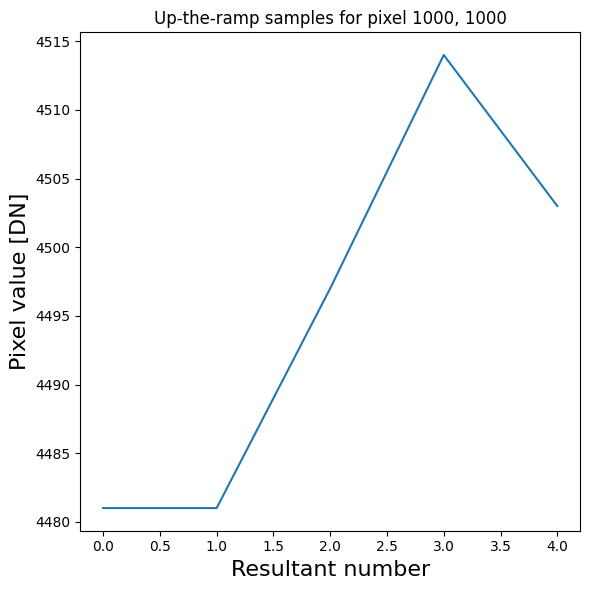

In [38]:
plt.figure(figsize=(6, 6), layout='tight')
plt.title('Up-the-ramp samples for pixel 1000, 1000')
plt.plot(g['roman']['data'][:, 1000, 1000])
plt.xlabel('Resultant number', fontsize=16)
plt.ylabel('Pixel value [DN]', fontsize=16);

The L1 data array contains all the uncalibrated resultants that, after processing, yield the L2 rate images.

The ASDF tree shows another section of the file called `romanisim` that contains information about the simulation that created the L1 file. This section is not part of the datamodel definition in `roman_datamodels`, therefore it cannot be accessed with the dot notation. Instead, we can access it, and any other additional information not stored by the datamodel definition, using the ASDF tree and bracket notation:

In [39]:
g.tree['romanisim']

{'drop_extra_dq': True,
 'filename': 'r0003201001001001004_0001_wfi01_f106_uncal.asdf',
 'level': 1,
 'persistence': {'A': 0.017,
  'alpha': 0.045,
  'dx': 50000.0,
  'gamma': 1,
  'index': array([    5920,     6201,     6202, ..., 16702999, 16703000, 16706403],
        shape=(9855,)),
  't': array([61344.00059815, 61344.00059815, 61344.00059815, ...,
         61344.00059815, 61344.00059815, 61344.00059815], shape=(9855,)),
  'x': array([3203., 5999., 9530., ..., 3330., 3233., 4257.], shape=(9855,)),
  'x0': 60000.0},
 'simcatobj': array([(3251.983 , 4040.971 ,  21785.023, 0.35568213),
        (1823.7552, 2680.9565, 177165.3  , 0.5802121 ),
        (3233.524 , 1925.616 ,  37155.234, 0.17799616), ...,
        (2157.5808, 1560.2335,  60534.867, 0.03560209),
        (3014.4307, 1141.291 ,  40358.457, 0.03438997),
        (1880.8948, 2002.2448,  91580.14 , 0.03474903)],
       shape=(1745,), dtype=[('x', '<f4'), ('y', '<f4'), ('counts', '<f4'), ('time', '<f4')]),
 'simulate_reffiles': {'da

Similarly, we can access the previously mentioned history section of the file using the ASDF tree and bracket notation to find some package version information that may be useful to us. This includes, for example, the `roman_datamodels` version used to create the file.

In [40]:
g.tree['history']

{'extensions': [{'extension_class': 'asdf.extension._manifest.ManifestExtension',
   'extension_uri': 'asdf://asdf-format.org/core/extensions/core-1.6.0',
   'manifest_software': {'name': 'asdf_standard', 'version': '1.1.1'},
   'software': {'name': 'asdf', 'version': '4.1.0'}},
  {'extension_class': 'asdf.extension._manifest.ManifestExtension',
   'extension_uri': 'asdf://asdf-format.org/astronomy/gwcs/extensions/gwcs-1.3.0',
   'manifest_software': {'name': 'asdf_wcs_schemas', 'version': '0.4.0'},
   'software': {'name': 'gwcs', 'version': '0.22.1'}},
  {'extension_class': 'asdf.extension._manifest.ManifestExtension',
   'extension_uri': 'asdf://astropy.org/astropy/extensions/units-1.0.0',
   'software': {'name': 'asdf-astropy', 'version': '0.7.1'}},
  {'extension_class': 'asdf.extension._manifest.ManifestExtension',
   'extension_uri': 'asdf://stsci.edu/datamodels/roman/extensions/datamodels-1.0',
   'manifest_software': {'name': 'rad', 'version': '0.23.1'},
   'software': {'name': 

During Roman development, you may have an outdated version of a file that does not conform to the installed version of `roman_datamodels`, but you may want to open the file anyway. This may be to just get something out of the file that you need, or you may want to try manually fixing the file to conform to the latest schema. In any case, you can still open the file with `asdf.open()` if you disable the schema validation like so:

In [41]:
asdf_file_uri_l1 = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_uncal.asdf'

with fs.open(asdf_file_uri_l1, 'rb') as fb:
    with asdf.config_context() as cfg:
        cfg.validate_on_read = False
        af = asdf.open(fb)

Note that if your file does not conform to the installed version of `roman_datamodels`, then you will need to leave it as an `AsdfFile` object and not try to pass it to `roman_datamodels.open()`.

## Additional Resources

For more information about Roman data products and additional resources please consider visiting the links below:

- [Roman User Documentation -- RDox](https://roman-docs.stsci.edu/)
- [MAST](https://archive.stsci.edu)
- [ASDF python API](https://asdf.readthedocs.io/en/latest/)
- [ASDF standard](https://asdf-standard.readthedocs.io/)

## About this Notebook

**Author:** Javier Sánchez, William Schultz, Tyler Desjardins 

**Updated On:** 2025-05-26

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 